In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default")
from tqdm import trange, tqdm
from IPython.display import display

import scipy.io
from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("DEVICE:", device)

DEVICE: cuda


In [0]:
mydrive = "/content/drive/My Drive/Colab Notebooks/DeepLearning/"

In [0]:
# %% load data
mat = scipy.io.loadmat(mydrive+'MNIST.mat')
# input images
X = mat['input_images'] # np.array, shape=(60000 x 784)
                        # each row is a single image
                        # each column is a pixel of the image (28 x 28)
# labels
Y = np.squeeze(mat['output_labels']).astype(int)

In [5]:
# %% train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1995)

X_train = torch.from_numpy(X_train).to(device)
Y_train = torch.from_numpy(Y_train).to(device)
X_test  = torch.from_numpy(X_test).to(device)
Y_test  = torch.from_numpy(Y_test).to(device)

print("shape X_train: ",np.shape(X_train))
print("shape Y_train: ",np.shape(Y_train))
print("shape X_test: " ,np.shape(X_test))
print("shape Y_test: " ,np.shape(Y_test))

shape X_train:  torch.Size([48000, 784])
shape Y_train:  torch.Size([48000])
shape X_test:  torch.Size([12000, 784])
shape Y_test:  torch.Size([12000])


In [0]:
#%% Neural Network

### Define the network class
class Net(nn.Module):

    def __init__(self,
                 Ni  = 784,
                 Nh1 = 256,
                 Nh2 = 256,
                 No  = 10,
                 act = nn.ReLU):
        super().__init__()

        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)

        self.act = act()

    def forward(self, x, additional_out=False):

        x   = self.act(self.fc1(x))
        x   = self.act(self.fc2(x))
        out = self.fc3(x)

        if additional_out:
            return out, x

        return out

In [0]:
# %% training

def TRAIN(net, optimizer, X_train, Y_train, X_test, Y_test, epochs=3000, loss_fn=nn.CrossEntropyLoss()):
    train_loss_log = []
    test_loss_log = []
    #X_train = torch.from_numpy(X_train).to(device)
    #Y_train = torch.from_numpy(Y_train).to(device)
    #X_test  = torch.from_numpy(X_test).to(device)
    #Y_test  = torch.from_numpy(Y_test).to(device)
    for ep in range(epochs):
        net.train()
        optimizer.zero_grad()
        out = net(X_train)
        train_loss = loss_fn(out, Y_train)
        train_loss.backward()
        optimizer.step()
        # Validation
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # No need to track the gradients
            out = net(X_test)
            # Evaluate global loss
            test_loss = loss_fn(out, Y_test)
        train_loss_log.append(float(train_loss))
        test_loss_log .append(float(test_loss))
        """if (ep+1)%100 == 0:
            print(' '*5+"Epoche {} - Train Loss = {:.4f} - Test Loss = {:.4f}".format(ep+1, float(train_loss), float(test_loss)))"""
    return net, train_loss_log, test_loss_log

In [0]:
# %% Kfold cross validation

def kfoldCV(net, optimizer, X, Y, nfolds=5, epochs=3000, loss_fn=nn.CrossEntropyLoss(), rs=100):
    kf = KFold(nfolds, shuffle=True, random_state=rs)
    current_Fold = 1
    validation_losses = []
    for train_index, test_index in kf.split(X):
        #print("CV split {} / {}".format(current_Fold, nfolds))

        # get train/validation folds
        X_train, X_val = X[train_index], X[test_index]
        Y_train, Y_val = Y[train_index], Y[test_index]
        _, _, val_loss_log = TRAIN(net, optimizer, X_train, Y_train, X_val, Y_val, epochs=epochs, loss_fn=loss_fn)
        validation_losses.append(val_loss_log[-1])

        current_Fold += 1

    validation_loss = np.mean(validation_losses)

    return validation_loss

In [0]:
# %% parameters search
def ParametersSearch(Nh1, Nh2, optimizer, X, Y, nfolds=5, epoches=3000, device="cpu"):
    results = pd.DataFrame(columns=["Nh1", "Nh2", "Optimizer", "Val_Loss"])
    
    total_cycles = len(Nh1)*len(Nh2)*len(optimizer)
    it = 1
    
    for n1 in Nh1:
        for n2 in Nh2:
            for opt_name, opt in optimizer.items():
                print("Nh1 = {} | Nh2 = {} | Opt = {:7s} | Iter {} / {}".format(n1,n2,opt_name, it, total_cycles))
                net = Net(Nh1=n1, Nh2=n2)
                net.to(device)
                optim = opt(net.parameters())
                val_loss = kfoldCV(net, optim, X, Y, nfolds=nfolds, epochs=epoches, rs=None)
                log = pd.DataFrame({
                    "Nh1"       : [n1],
                    "Nh2"       : [n2],
                    "Optimizer" : [opt_name],
                    "Val_Loss"  : [val_loss]
                })
                results = results.append(log)
                it += 1
    results.sort_values(by="Val_Loss", inplace=True)
    return results

In [10]:
# %% Random Search
np.random.seed(784012)
Ni = 784
Nh1 = [256] + list(np.random.randint(100, 500, size=9))
Nh2 = [i**2 for i in range(11,21)]#[256] + list(np.random.randint(100, 500, size=9))
No = 10
optimizer = {"Adam":torch.optim.Adam, "RMSprop":torch.optim.RMSprop}

results = ParametersSearch(Nh1, Nh2, optimizer, X_train, Y_train, device=device, epoches=1000)


Nh1 = 256 | Nh2 = 121 | Opt = Adam    | Iter 1 / 200
Nh1 = 256 | Nh2 = 121 | Opt = RMSprop | Iter 2 / 200
Nh1 = 256 | Nh2 = 144 | Opt = Adam    | Iter 3 / 200
Nh1 = 256 | Nh2 = 144 | Opt = RMSprop | Iter 4 / 200
Nh1 = 256 | Nh2 = 169 | Opt = Adam    | Iter 5 / 200
Nh1 = 256 | Nh2 = 169 | Opt = RMSprop | Iter 6 / 200
Nh1 = 256 | Nh2 = 196 | Opt = Adam    | Iter 7 / 200
Nh1 = 256 | Nh2 = 196 | Opt = RMSprop | Iter 8 / 200
Nh1 = 256 | Nh2 = 225 | Opt = Adam    | Iter 9 / 200
Nh1 = 256 | Nh2 = 225 | Opt = RMSprop | Iter 10 / 200
Nh1 = 256 | Nh2 = 256 | Opt = Adam    | Iter 11 / 200
Nh1 = 256 | Nh2 = 256 | Opt = RMSprop | Iter 12 / 200
Nh1 = 256 | Nh2 = 289 | Opt = Adam    | Iter 13 / 200
Nh1 = 256 | Nh2 = 289 | Opt = RMSprop | Iter 14 / 200
Nh1 = 256 | Nh2 = 324 | Opt = Adam    | Iter 15 / 200
Nh1 = 256 | Nh2 = 324 | Opt = RMSprop | Iter 16 / 200
Nh1 = 256 | Nh2 = 361 | Opt = Adam    | Iter 17 / 200
Nh1 = 256 | Nh2 = 361 | Opt = RMSprop | Iter 18 / 200
Nh1 = 256 | Nh2 = 400 | Opt = Adam   

In [11]:
# %% save results dataframe and get best model
print("Parameters search results:\n", results, "\n\n")
results.to_csv(mydrive+"GridSearch_csv.csv"    , index=False)
results.to_latex(mydrive+"GridSearch_latex.txt", index=False)

best = results.iloc[0].to_dict()
print("Best Model:\n", best)
print("Validation loss =", best["Val_Loss"], "\n\n")
f = open(mydrive+"best_model.txt", "w")
print("Best Model:\n", best, file=f)
f.close()

Parameters search results:
     Nh1  Nh2 Optimizer   Val_Loss
0   280  121      Adam   0.030274
0   398  361      Adam   0.031036
0   398  225      Adam   0.032040
0   280  289      Adam   0.032480
0   173  400      Adam   0.032498
..  ...  ...       ...        ...
0   280  256   RMSprop   1.011974
0   361  324   RMSprop   1.096490
0   339  400   RMSprop   1.613980
0   262  324   RMSprop   4.731198
0   339  324   RMSprop  14.190023

[200 rows x 4 columns] 


Best Model:
 {'Nh1': 280, 'Nh2': 121, 'Optimizer': 'Adam', 'Val_Loss': 0.03027381525898818}
Validation loss = 0.03027381525898818 




In [0]:
# %% train best model on the whole training set and save it
net = Net(Nh1=best["Nh1"], Nh2=best["Nh2"])
net.to(device)
opt = optimizer[best["Optimizer"]]
opt = optim = opt(net.parameters())
net, train_loss_log, test_loss_log = TRAIN(net, opt, X_train, Y_train, X_test, Y_test, epochs=3000, loss_fn=nn.CrossEntropyLoss())
#torch.save(net.state_dict(), mydrive+"best_model.torch")

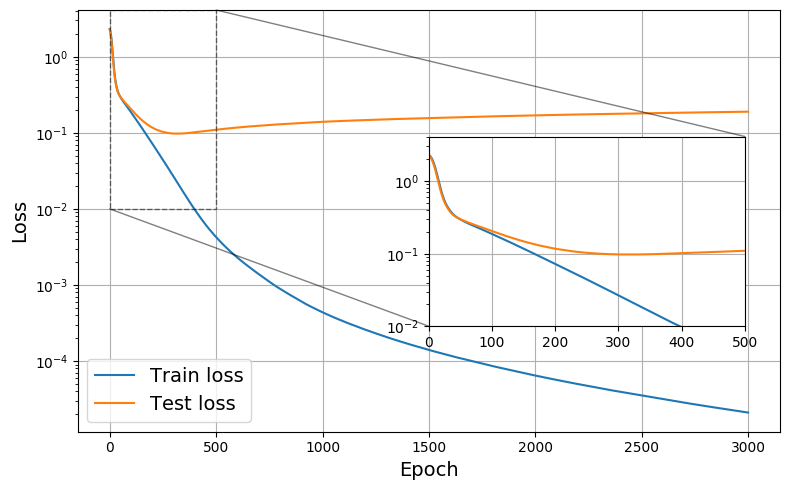

In [61]:
# %% plot losses
plt.close("all")
fig, ax = plt.subplots(figsize=(8,5))
ax.semilogy(train_loss_log, label='Train loss')
ax.semilogy(test_loss_log,  label='Test loss')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.grid()
ax.legend(loc="lower left", fontsize=14)
axins = ax.inset_axes([.5, .25, .45, .45])
axins.semilogy(train_loss_log, label='Train loss')
axins.semilogy(test_loss_log,  label='Test loss')
axins.set_xlim(0, 500)
axins.set_ylim(1e-02)
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")
fig.tight_layout()
fig.savefig(mydrive+"Loss.pdf")
plt.show()

In [0]:
# %% train best model on the whole training set and save it
net = Net(Nh1=best["Nh1"], Nh2=best["Nh2"])
net.to(device)
opt = optimizer[best["Optimizer"]]
opt = optim = opt(net.parameters())
net, train_loss_log, test_loss_log = TRAIN(net, opt, X_train, Y_train, X_test, Y_test, epochs=350, loss_fn=nn.CrossEntropyLoss())
torch.save(net.state_dict(), mydrive+"best_model.torch")

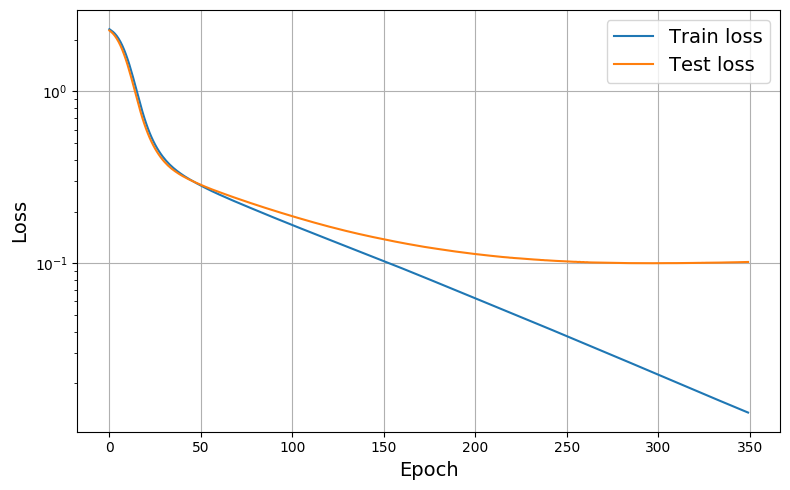

In [65]:
# %% plot losses
plt.close("all")
plt.figure(figsize=(8,5))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log,  label='Test loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig(mydrive+"Loss.pdf")
plt.show()

In [66]:
# %% prediction on test set
net.eval()
with torch.no_grad():
    y_pred = net(X_test)
y_pred = F.log_softmax(y_pred, dim=1)
_, y_class = y_pred.max(1)
np_Y_test = Y_test.cpu().numpy()
np_y_pred = y_class.cpu().numpy()
correct = np.sum(np_Y_test == np_y_pred)
print("Accuracy = {:.5f} %".format(correct*100/np_Y_test.shape[0]))
f = open(mydrive+"best_model.txt", "a")
f.write("\n\nAccuracy on test set = {:.5f} %".format(correct*100/np_Y_test.shape[0]))
f.close()

Accuracy = 97.20000 %


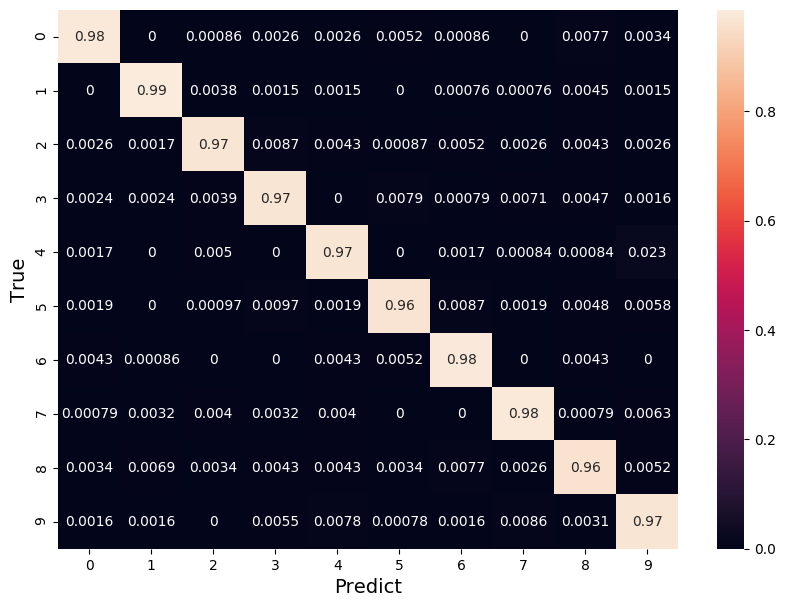

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix (normalized over rows, e.g. true labels)
confusion = confusion_matrix(np_Y_test, np_y_pred, normalize="true")
df_confusion = pd.DataFrame(confusion, index = [i for i in range(10)], columns = [i for i in range(10)])
# plot entire confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(df_confusion, annot=True)
plt.xlabel("Predict", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.savefig(mydrive+"Confusion_complete.pdf")
plt.show()

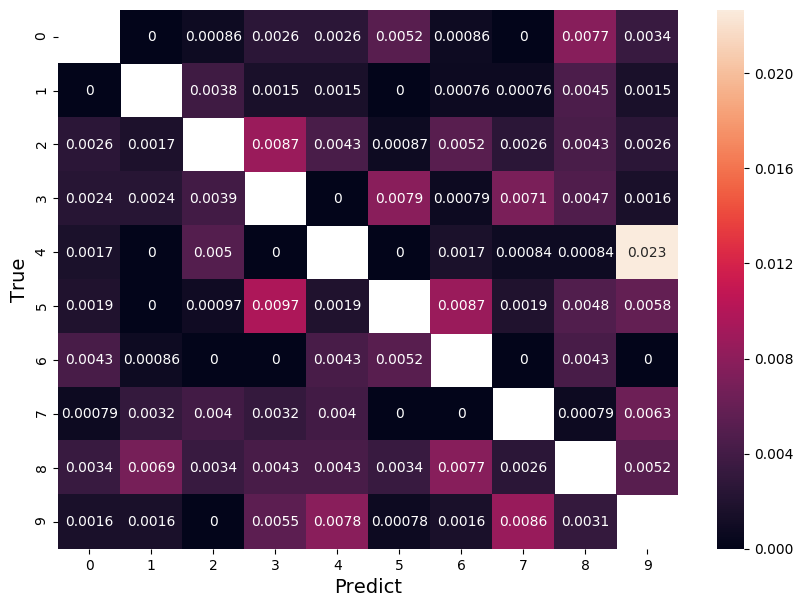

In [68]:
df_confusion[df_confusion > 0.5] = np.nan
plt.figure(figsize = (10,7))
sns.heatmap(df_confusion, annot=True)
plt.xlabel("Predict", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.savefig(mydrive+"Confusion_errors.pdf")
plt.show()

In [0]:
# %% Access network parameters
h1_w = net.fc1.weight.cpu().data.numpy()
h1_b = net.fc1.bias.cpu().data.numpy()
h2_w = net.fc2.weight.cpu().data.numpy()
h2_b = net.fc2.bias.cpu().data.numpy()
h3_w = net.fc3.weight.cpu().data.numpy()
h3_b = net.fc3.bias.cpu().data.numpy()

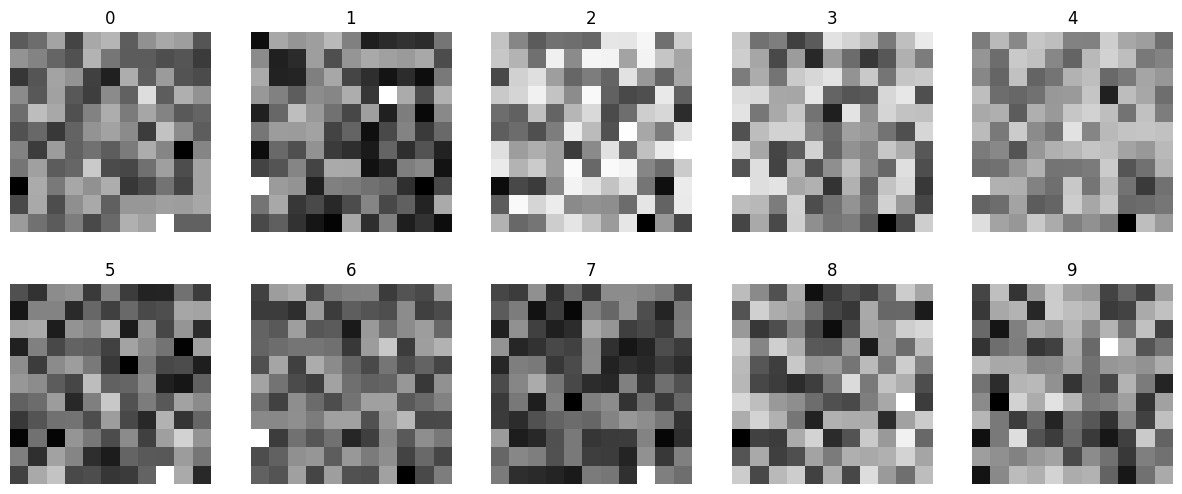

In [70]:
# %% Plot last layer receptive field
plt.close("all")
plt.figure(figsize=(15,6))
dim = int(len(h3_w[0])**0.5)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis("off")
    plt.imshow(h3_w[i].reshape(dim,dim).T, cmap="gray")
    plt.title(i)
plt.savefig(mydrive+"ReceptiveField.pdf")
plt.show()

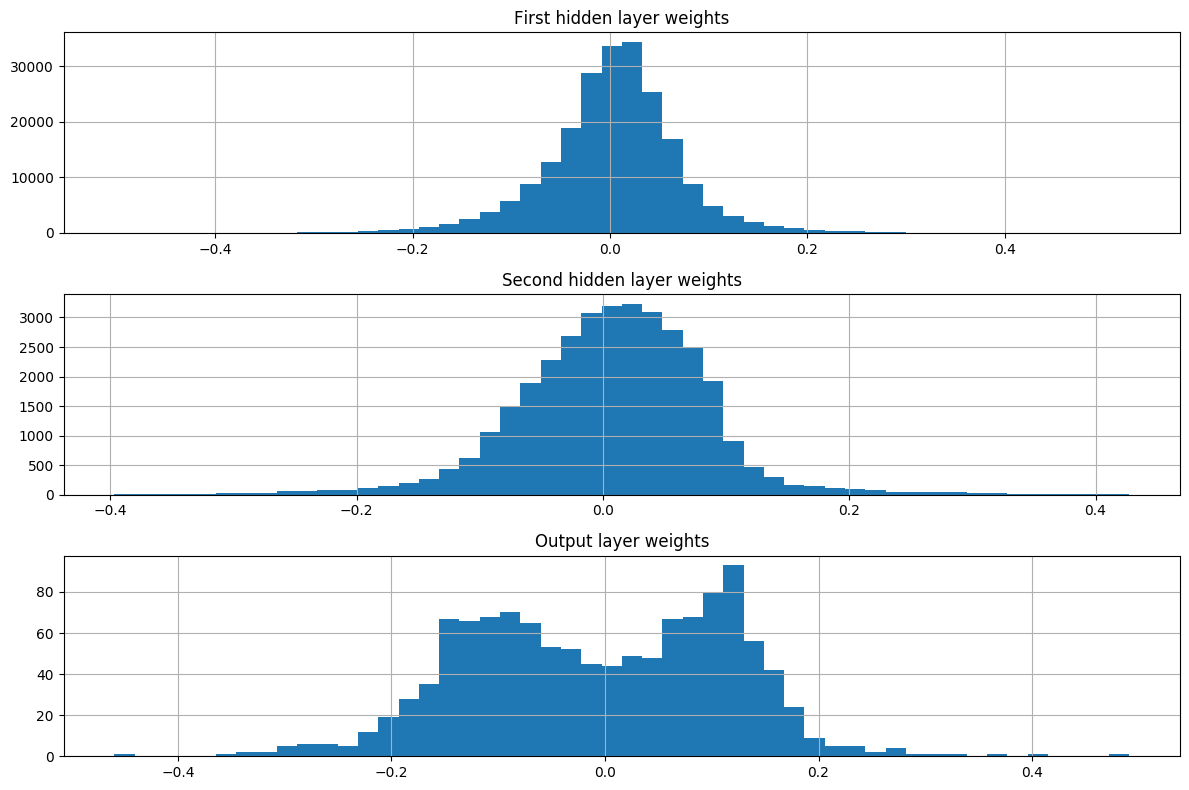

In [71]:
# %% Weights histogram
plt.close("all")
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig(mydrive+"Weights.pdf")
plt.show()